In [1]:
cd ~/git/mouse-placenta-development/

/Users/starks/git/mouse-placenta-development


In [14]:
import sys
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
from itertools import product
from dataclasses import dataclass

sys.path.append('/Users/starks/git/mouse-placenta-development/irtoolkit/')
import viz

In [4]:
path = './data/chemical-images/1-merged-regions/sample-slide-1-region-J.h5'
with h5py.File(path, 'r') as f:
    wn = f.attrs['wavenumber']
    img = f['raw'][:, :, wn.tolist().index(1150)]

In [6]:
fga = viz.SlideSection(
    slice(1000, 1200),
    slice(400, 500),
    color=sns.color_palette()[0],
    name='foreground - internal'
)

fgb = viz.SlideSection(
    slice(1100, 1250),
    slice(700, 800),
    color=sns.color_palette()[1],
    name='foreground - external'
)

bga = viz.SlideSection(
    slice(400, 600),
    slice(700, 800),
    color=sns.color_palette()[2],
    name='background - bottom'
)

bgb = viz.SlideSection(
    slice(800, 900),
    slice(25, 75),
    color=sns.color_palette()[3],
    name='background - top'
)

boxes = [bga, bgb, fga, fgb]

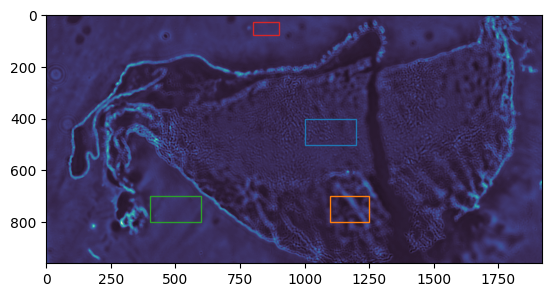

In [7]:
with h5py.File(path, 'r') as f:
    wn = f.attrs['wavenumber'].astype(int)
    img = f['raw'][:, :, wn.tolist().index(1150)]

    fig, ax = plt.subplots()
    ax.imshow(img, cmap=sns.color_palette('mako', as_cmap=True))
    for box in boxes:
        ax.add_patch(box.make_patch())
        
    plt.show()

In [8]:
def lineplot(box, f, key, nsamples=None, ax=None):
    if ax is None:
        _, ax = plt.subplots()

    df = box.df(f, key, melt=False)

    sns.lineplot(
        data=df.melt(ignore_index=False).reset_index(),
        x='wn', y='value', errorbar='pi',
        color=box.color, label=box.name,
    )
    
    if nsamples is not None and nsamples > 0:
        sns.lineplot(
            data=df.sample(nsamples).melt(ignore_index=False).reset_index(),
            x='wn', y='value', errorbar='pi',
            units='index', estimator=None, lw=1,
            color=box.color, alpha=0.15
        )

    return ax

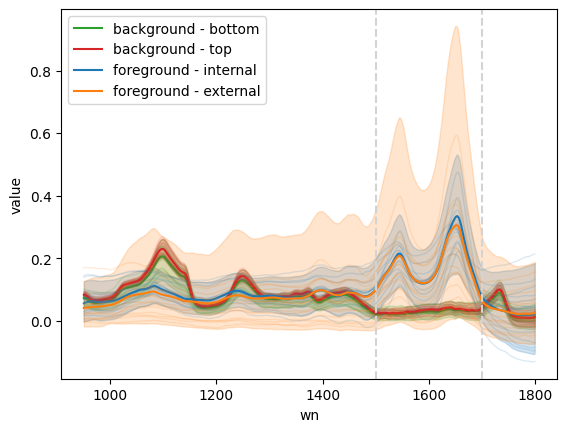

In [9]:
fig, ax = plt.subplots()

with h5py.File(path, 'r') as f:
    for box in boxes:
        lineplot(box, f, 'raw', nsamples=15, ax=ax)

ax.axvline(1500, color='lightgrey', ls='--')
ax.axvline(1700, color='lightgrey', ls='--')

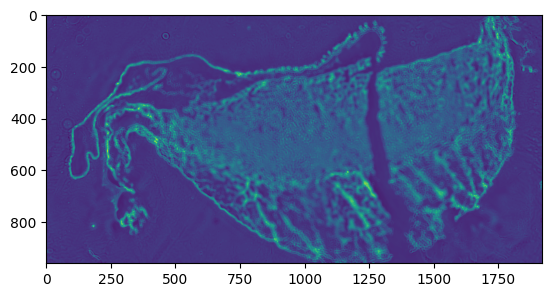

In [13]:
with h5py.File(path, 'r') as f:
    wn = f.attrs['wavenumber'].astype(int)
    
    start, end = np.argmax(wn > 1500), np.argmax(wn > 1700)
    img = f['raw'][:, :, start:end].mean(2)
plt.imshow(img)

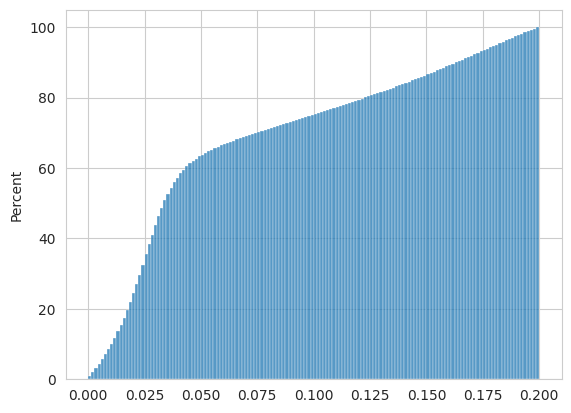

In [15]:
with sns.axes_style('whitegrid'):
    sns.histplot(img.ravel(), cumulative=True, binrange=(0, 0.2), stat='percent')

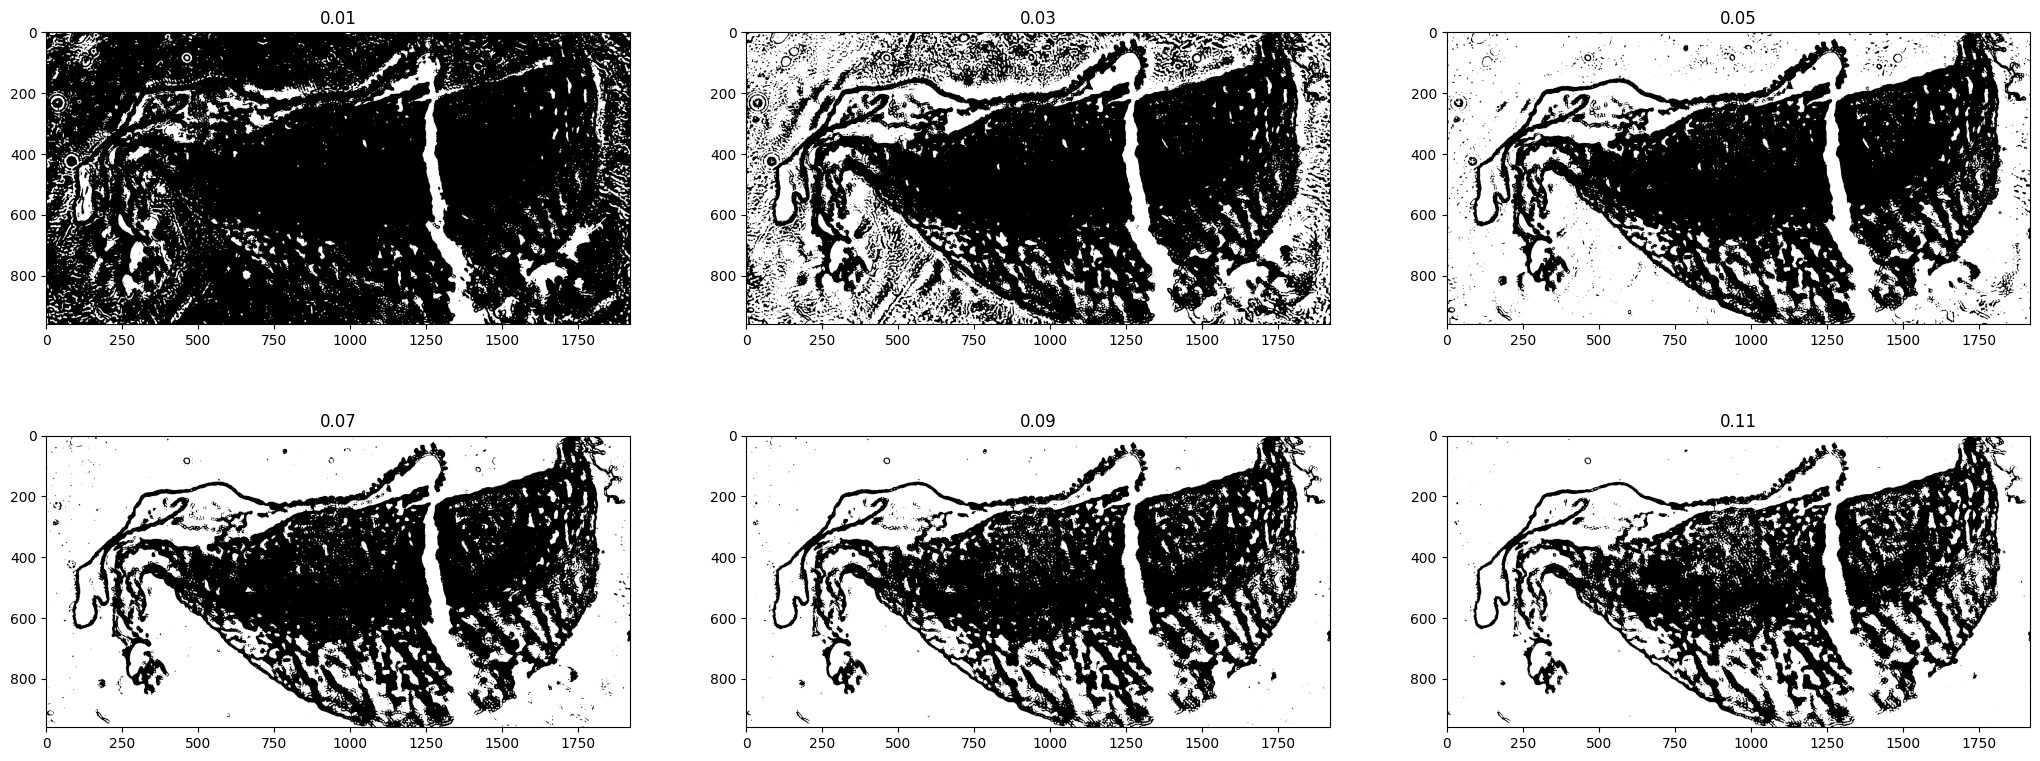

In [19]:
tholds = [0.01, 0.03, 0.05, 0.07, 0.09, 0.11]

fig, axes = plt.subplots(len(tholds)// 3, 3, figsize=(6.4*4, 4.8*2))
for ax, thold in zip(axes.ravel(), tholds):
    ax.imshow((img > thold).astype(np.uint8), cmap='Greys')
    ax.set_title(thold)

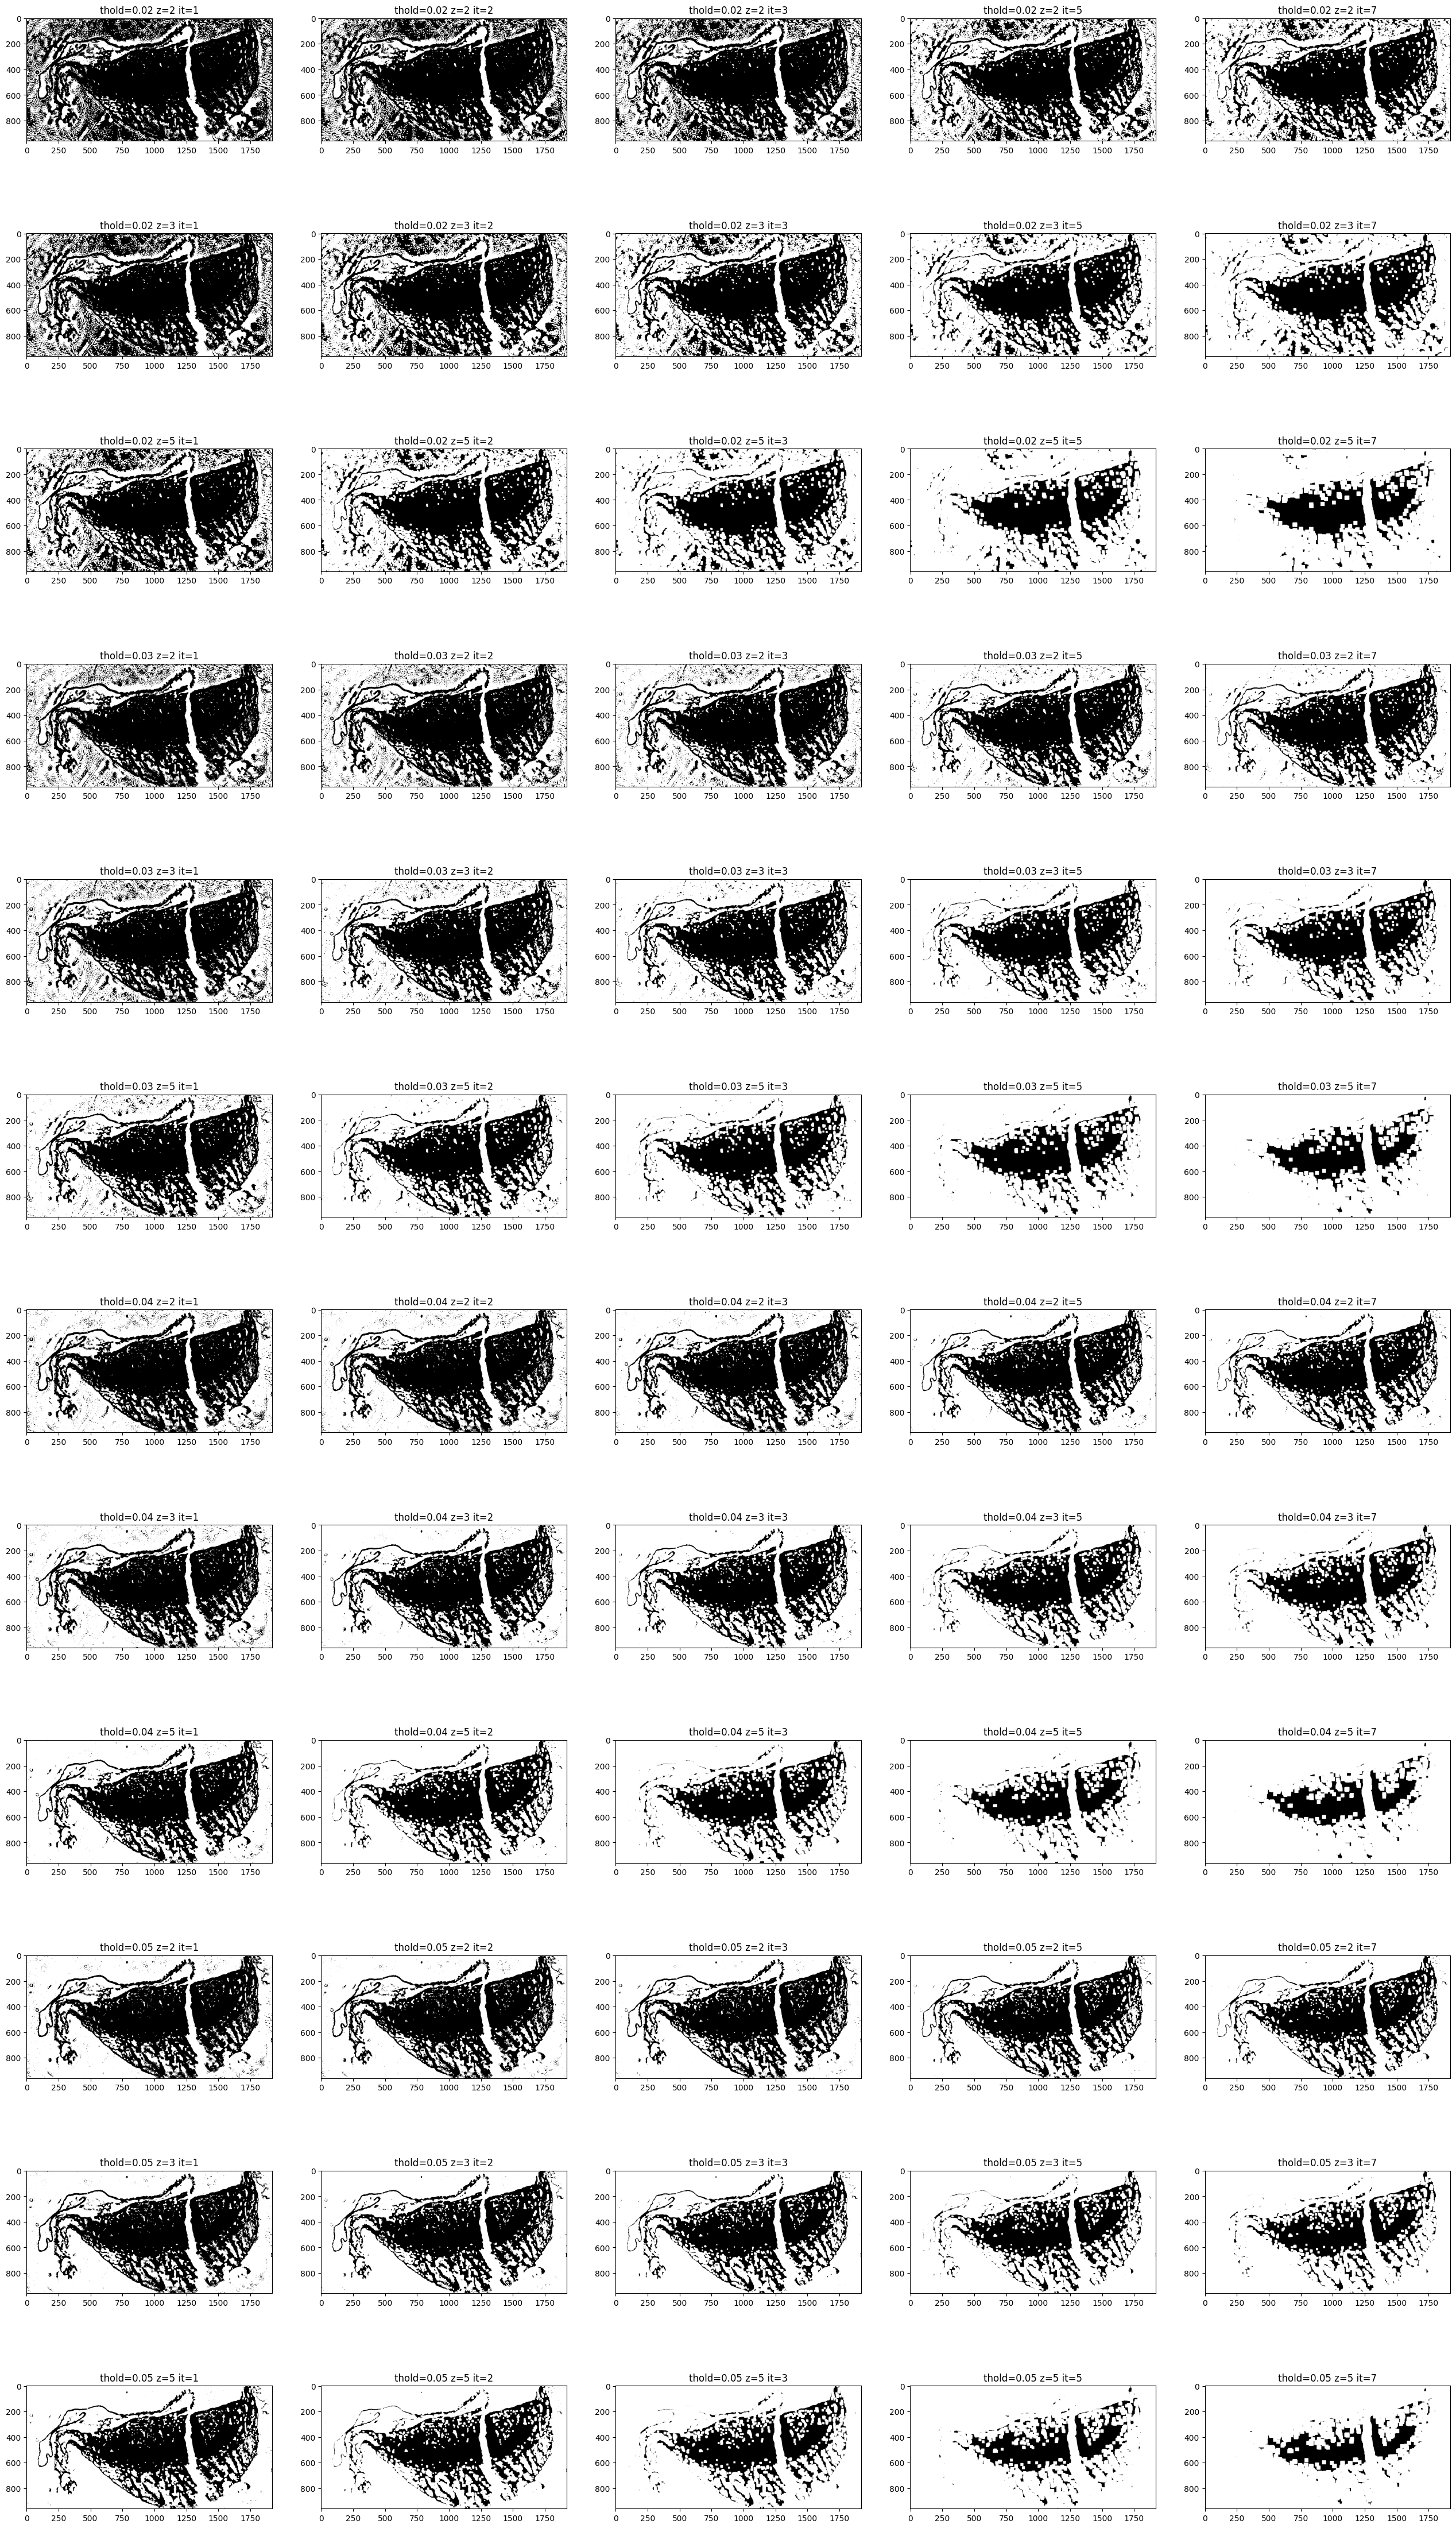

In [35]:
tholds = [0.02, 0.03, 0.04, 0.05,]
iters = [1, 2, 3, 5, 7]
kernel_sizes = [2, 3, 5]

settings = list(product(
    tholds, kernel_sizes, iters, 
))

ncols = 5
nrows = len(settings) // ncols
assert nrows * ncols == len(settings)

fig, axes = plt.subplots(nrows, ncols, figsize=(6.4 * ncols, 4.8 * nrows))
for ax, (thold, z, it) in zip(axes.ravel(), settings):
    ax.set_title(f'thold={thold} z={z} it={it}')
    kernel = np.ones((z, z), np.uint8)
    ax.imshow(
        cv2.erode(
            (img > thold).astype(np.uint8),
            kernel,
            iterations=it),
        cmap='Greys'
    )

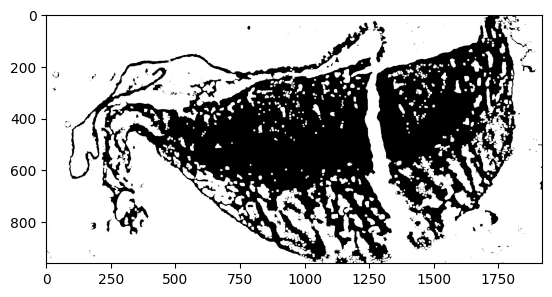

In [40]:
final_thold = 0.05
final_z = 3
final_it = 2

kernel = np.ones((final_z, final_z), np.uint8)
plt.imshow(
    cv2.erode(
        (img > final_thold).astype(np.uint8),
        kernel,
        iterations=final_it),
    cmap='Greys'
)

In [ ]:
'''
background_detection:

    wn_region:
        start: 1500
        end: 1700

    masking_parameters:
        masking_thold: 0.05
        erosion_kernel_size: 3
        erosion_iterations: 2

'''